<a href="https://colab.research.google.com/github/o7s8r6/CVIVAAN/blob/main/image_classifier_deployment_on_oak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

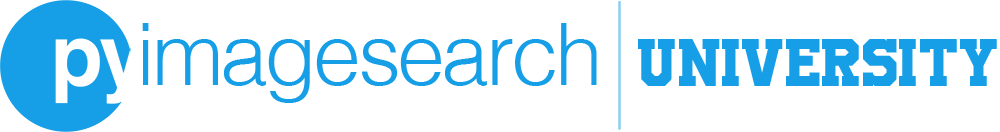

# Deploying a Custom Image Classifier on an OAK-D
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Deploying a Custom Image Classifier on an OAK-D](https://pyimg.co/tnx0u) blog post published on 2023-04-03.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*PyImageSearch Team*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2023 OptiReto, LLC and PyImageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

# Deploying the Model on OAK

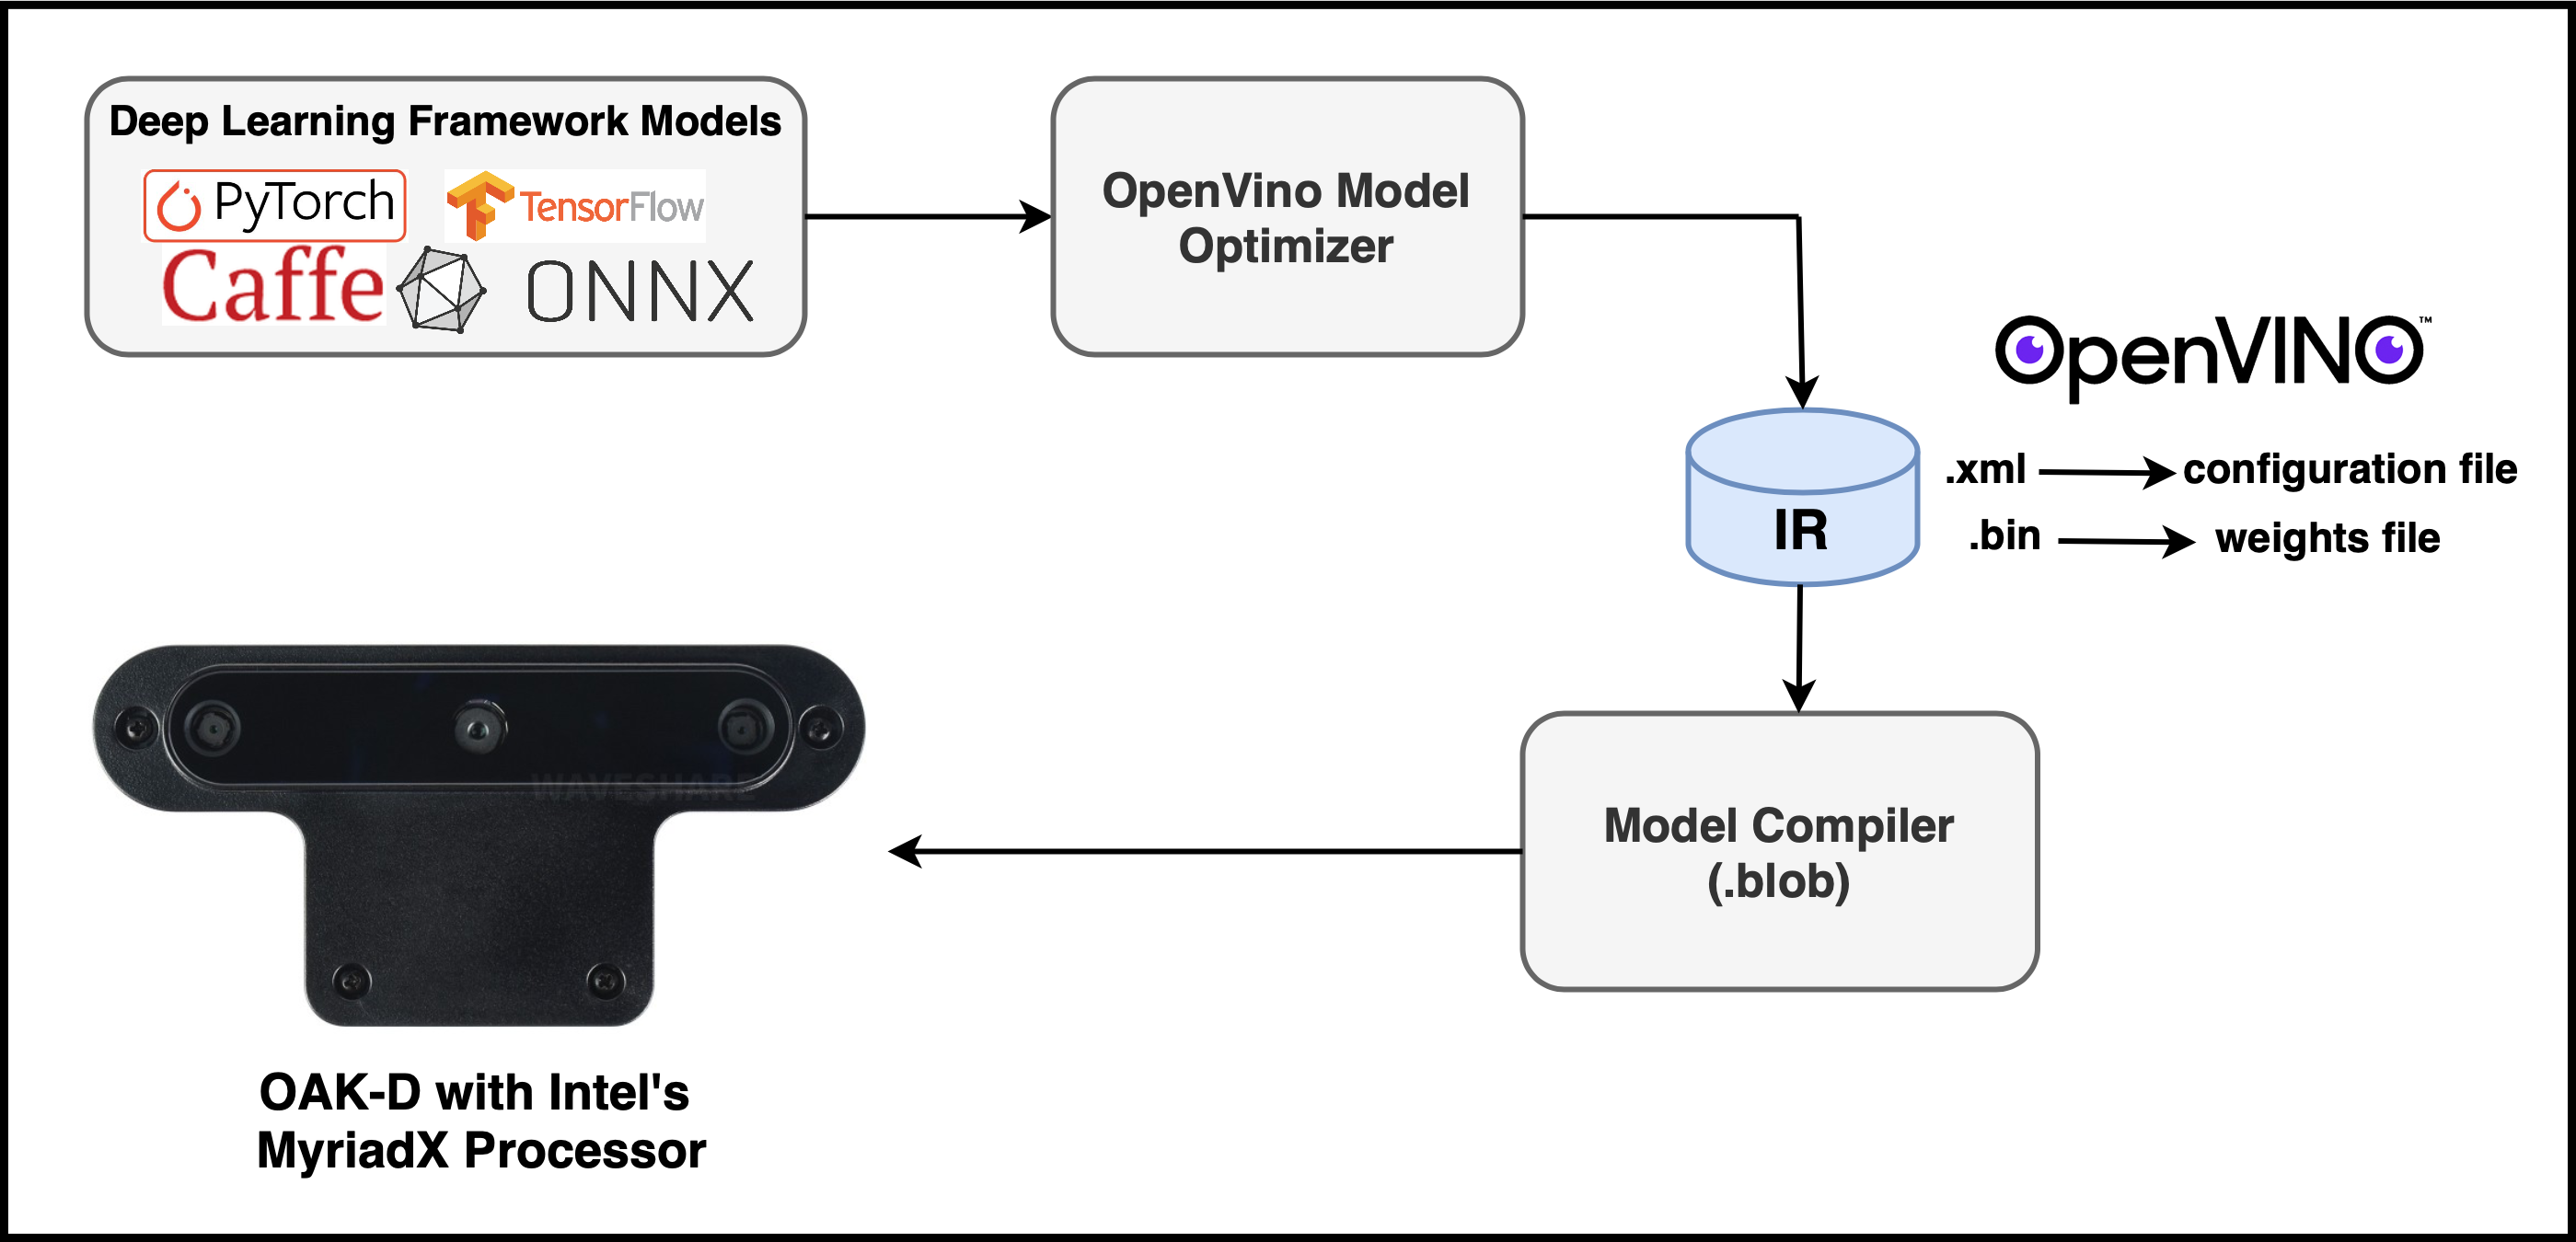

### Download the code zip file

In [ ]:
! wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/training-image-classifier-for-OAK/training-image-classifier-for-OAK.zip
! unzip -qq training-image-classifier-for-OAK.zip
%cd training-image-classifier-for-OAK

--2023-03-17 05:50:53--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/training-image-classifier-for-OAK/training-image-classifier-for-OAK.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 3.5.85.176, 52.218.128.141, 52.92.137.50, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|3.5.85.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10693319 (10M) [binary/octet-stream]
Saving to: ‘training-image-classifier-for-OAK.zip’

training-image-clas 100%[===================>]  10.20M  2.16MB/s    in 9.1s    

2023-03-17 05:51:03 (1.12 MB/s) - ‘training-image-classifier-for-OAK.zip’ saved [10693319/10693319]

/content/training-image-classifier-for-OAK


## Blog Post Code

### Intel OpenVINO toolkit Installation

In [ ]:
%%time 
%%capture
# install tools. OpenVino takes some time to download: 5-10 mins.
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove
## download installation files
!wget https://registrationcenter-download.intel.com/akdlm/irc_nas/18319/l_openvino_toolkit_p_2021.4.752.tgz
path = "l_openvino_toolkit_p_2021.4.752.tgz"
## install openvino
!tar xf "{path}"

CPU times: user 189 ms, sys: 54.7 ms, total: 244 ms
Wall time: 25.8 s


In [ ]:
%%capture
%cd l_openvino_toolkit_p_2021.4.752/
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

#### Changing the TensorFlow Version

The google colab by default comes with Python 3.9 and `requirements.txt` in OpenVino installs tensorflow~=2.4.1 version, however, tensorflow 2.4.1 has no wheels for Python 3.9. Hence, in the next few cells we modify the `requirements.txt` and allow OpenVino to install a tensorflow version equal or greater than 2.5. 

In [ ]:
!cat /opt/intel/openvino_2021.4.752/deployment_tools/model_optimizer/requirements.txt

tensorflow~=2.4.1
mxnet~=1.2.0; sys_platform == 'win32'
mxnet~=1.7.0.post2; sys_platform != 'win32'
networkx~=2.5
numpy>=1.16.6,<1.20
protobuf>=3.15.6
onnx>=1.8.1
defusedxml>=0.7.1
urllib3>=1.26.4
requests>=2.25.1


In [ ]:
!sed -i 's/tensorflow~=2.4.1/tensorflow~=2.5/g' /opt/intel/openvino_2021.4.752/deployment_tools/model_optimizer/requirements.txt

In [ ]:
!cat /opt/intel/openvino_2021.4.752/deployment_tools/model_optimizer/requirements.txt

tensorflow~=2.5
mxnet~=1.2.0; sys_platform == 'win32'
mxnet~=1.7.0.post2; sys_platform != 'win32'
networkx~=2.5
numpy>=1.16.6,<1.20
protobuf>=3.15.6
onnx>=1.8.1
defusedxml>=0.7.1
urllib3>=1.26.4
requests>=2.25.1


In [ ]:
%%capture
# install framework prerequisites (configures model optimizer for the framework)
!/opt/intel/openvino_2021.4.752/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh

In [ ]:
%%capture
!pip install -U --no-deps --quiet openvino

### Check Open Vino installation

In [ ]:
!source /opt/intel/openvino_2021.4.752/bin/setupvars.sh && \
    /opt/intel/openvino_2021.4.752/deployment_tools/demo/demo_squeezenet_download_convert_run.sh

[setupvars.sh] OpenVINO environment initialized
target_precision = FP16
[setupvars.sh] OpenVINO environment initialized


###################################################



Installing dependencies
Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Hit:9 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:12 http://ppa.

### Convert Vegetable Classifier TensorFlow Model to OpenVINO IR format

Use the openvino model optimizer to convert the Image Classifier model to IR. 

In [ ]:
#CONVERT MODEL to OPEN VINO IR.
%cd /content/training-image-classifier-for-OAK
!source /opt/intel/openvino_2021.4.752/bin/setupvars.sh && \
    python /opt/intel/openvino_2021.4.752/deployment_tools/model_optimizer/mo_tf.py \
      --saved_model_dir="output/vegetable_classifier" \
      --input_shape="[1,224,224,3]" \
      --data_type="FP32" \
      --output_dir="output/vegetable_classifier/IR_models/FP32" \
      --model_name="vegetable_classifier"

/content/training-image-classifier-for-OAK
[setupvars.sh] OpenVINO environment initialized
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/content/training-image-classifier-for-OAK/output/vegetable_classifier/IR_models/FP32
	- IR output name: 	vegetable_classifier
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers

In [ ]:
#check directory containing the exported IR model
%ls output/vegetable_classifier/IR_models/FP32/

vegetable_classifier.bin      vegetable_classifier.xml
vegetable_classifier.mapping


### Validate the OpenVINO IR

#### Import the necessary packages

In [ ]:
import os
import shutil
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from google.colab import files
from openvino.inference_engine import IECore

In [ ]:
def preprocess_input_image(imagePath, img_height=224):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Normalize to keep data between 0 - 1
    image = np.array(image) 

    # Change data layout from HWC to CHW
    image = image.transpose((2, 0, 1))
    input_image = image.reshape((n, c, h, w))

    return input_image

#### Run the inference

In [ ]:
class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 
               'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

In [ ]:
model_xml = "output/vegetable_classifier/IR_models/FP32/vegetable_classifier.xml"
model_bin = "output/vegetable_classifier/IR_models/FP32/vegetable_classifier.bin"
test_images = glob.glob("test-images/*.jpg")

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)
exec_net = ie.load_network(network=net, device_name="CPU")
del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

# Run the Inference on the test images
for image_path in test_images:
  #Pre-process the image and get it ready for inference.
  input_image = preprocess_input_image(image_path)

  res = exec_net.infer(inputs={input_layer: input_image})
  res = res[output_layer]

  score = tf.nn.softmax(res[0])

  true_label = image_path.split("/")[1].split(".")[0]
  print(
      "The true label of the image is {}. Prediction - {} with a {:.2f} percent confidence."
      .format(true_label, class_names[np.argmax(score)], 100 * np.max(score))
  )

The true label of the image is brinjal. Prediction - Brinjal with a 97.72 percent confidence.
The true label of the image is papaya. Prediction - Papaya with a 99.57 percent confidence.
The true label of the image is cauliflower. Prediction - Cauliflower with a 99.97 percent confidence.
The true label of the image is carrot. Prediction - Carrot with a 100.00 percent confidence.
The true label of the image is bean. Prediction - Bean with a 99.88 percent confidence.
The true label of the image is bitter_gourd. Prediction - Bitter_Gourd with a 99.95 percent confidence.


### Now we compile the IR model to a .blob for use on DepthAI modules/platforms

### Convert OpenVINO IR to Blob format 

In [ ]:
!source /opt/intel/openvino_2021.4.752/bin/setupvars.sh && \
/opt/intel/openvino_2021.4.752/deployment_tools/inference_engine/lib/intel64/myriad_compile -m output/vegetable_classifier/IR_models/FP32/vegetable_classifier.xml -ip U8 -VPU_NUMBER_OF_SHAVES 8 -VPU_NUMBER_OF_CMX_SLICES 8

[setupvars.sh] OpenVINO environment initialized
Inference Engine: 
	IE version ......... 2021.4.2
	Build ........... 2021.4.2-3974-e2a469a3450-releases/2021/4
[Warning][VPU][Config] Deprecated option was used : VPU_MYRIAD_PLATFORM
Done


### Now you can download your .blob file and run it on the DepthAI module/platform
To download locally, use the file explorer on the left to locate the file in the --output_dir folder, then right click download. Colab takes a few seconds to prepare the file, then the download prompt will appear.

In [ ]:
#download the blob file to local directory.
files.download('output/vegetable_classifier/IR_models/FP32/vegetable_classifier.blob')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Deploying a Custom Image Classifier on an OAK-D*](https://pyimg.co/tnx0u) published on 2023-04-03.

# Code License Agreement
```
Copyright (c) 2023 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from OptiReto, LLC and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```